# Reflector Position Optimization - Office Building Floor

This notebook implements physics-aware optimal placement for mechanical reflectors in NLOS (Non-Line-of-Sight) scenarios.

## Project Overview
- **Goal**: Find optimal deployment position for a mechanical reflector using gradient descent
- **Scenario**: Office Building Floor where direct LOS between Tx and Rx is blocked
- **Reflector Model**: Base plate with multiple tiles, each with limited rotation range (±60°)
- **Approach**: Optimize installation parameters (mount position, base orientation) considering mechanical constraints

In [1]:
# Import Required Libraries
import tensorflow as tf
import numpy as np
import sionna
from sionna.rt import Scene, load_scene
import matplotlib.pyplot as plt
import mitsuba as mi
import drjit as dr
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, \
                    PathSolver, RadioMaterial, cpx_abs_square, RadioMapSolver, RadioMap
import torch

print(f"TensorFlow version: {tf.__version__}")
print(f"Sionna version: {sionna.__version__}")

2026-01-30 09:51:03.972028: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-30 09:51:04.963425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-30 09:51:06.384630: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/hieule/research/reflector-position/.venv/lib/python3.

TensorFlow version: 2.20.0
Sionna version: 1.2.1


In [2]:
# Load the scene and add Transmitter and Receiver
scene = load_scene("/home/hieule/blender/models/building_floor/building_floor.xml")
scene.frequency = 5.18e9  # 5.18 GHz
# scene.frequency = 28e9  # 28 GHz
spped_of_light = 3e8  # m/s
wavelength = spped_of_light / scene.frequency

# Add Transmitter (Tx)
scene.tx_array = PlanarArray(num_rows=2,
                        num_cols=1,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="tr38901",
                        polarization="VH"
                        )
total_power_dbm = 5.0
n_txs = 1
txs = []
for i in range(n_txs):
    # the orientation is in radians: [roll, pitch, yaw]
    # we assign different yaw angles to the transmitters so that they point in different directions equally spacedly
    tx = Transmitter(name=f"Tx{i:02d}",
                    position=[10, 20 - i * 2 * wavelength, 3.8],
                    orientation=[i * 2 * np.pi / n_txs, 0, 0],
                    power_dbm=total_power_dbm/n_txs,)
    txs.append(tx)
    scene.add(tx)
# tx00 = Transmitter(name="Tx00",
#                 position=[10, 20, 3.8],
#                 orientation=[0, 0, 0],
#                 power_dbm=total_power_dbm/n_txs,)
# tx01 = Transmitter(name="Tx01",
#                 position=[10, 20, 3.8],
#                 orientation=[np.pi/2, 0, 0],
#                 power_dbm=total_power_dbm/n_txs,)
# scene.add(tx00)
# scene.add(tx01)
# Add Receiver (Rx) - Deep in the North Leg
# Position: x=1.5, y=10, z=1.5 (user height)
scene.rx_array = PlanarArray(num_rows=2,
                        num_cols=2,
                        vertical_spacing=0.5,
                        horizontal_spacing=0.5,
                        pattern="iso",
                        polarization="VH"
                        )
rx = Receiver(name="Rx",
                position=[16, 6.5, 1.5],
                orientation=[0, 0, 0])
scene.add(rx)


# Create a Controllable Flat Reflector

Now we'll create a single flat reflector (representing a simplified version of the multi-tile reflector system). The reflector will:
1. Be movable along a wall
2. Have efficiently controllable orientation using angles (α, β, γ)
3. Use a metal material with high reflectivity

In [3]:
# Create a reflector material - highly reflective metal
reflector_material = sionna.rt.ITURadioMaterial(
    name="reflector_metal",
    itu_type="metal",
    thickness=0.002,  # 2mm thick metal plate
    # color=(0.5, 0.5, 0.55)  # Light silver color for visualization
)

# Create a flat rectangular reflector using a plane/rectangle shape
# We'll create it as a simple rectangular mesh
import numpy as np

def create_flat_reflector_mesh(width=2.0, height=2.0):
    """
    Creates a flat rectangular reflector mesh centered at origin
    
    Args:
        width: Width of reflector in meters (along y-axis)
        height: Height of reflector in meters (along z-axis)
    
    Returns:
        Mitsuba mesh object
    """
    # Define vertices for a rectangle in the y-z plane (normal along x-axis)
    # This orientation makes it easier to position along walls
    w2, h2 = width/2, height/2
    vertices = np.array([
        [-0.01, -w2, -h2],  # Bottom-left
        [-0.01,  w2, -h2],  # Bottom-right  
        [-0.01,  w2,  h2],  # Top-right
        [-0.01, -w2,  h2],  # Top-left
    ], dtype=np.float32)
    
    # Define two triangular faces (rectangle = 2 triangles)
    faces = np.array([
        [0, 1, 2],  # First triangle
        [0, 2, 3],  # Second triangle
    ], dtype=np.uint32)
    
    # Create Mitsuba mesh
    mesh = mi.Mesh(
        "reflector_mesh",
        vertex_count=len(vertices),
        face_count=len(faces),
        has_vertex_normals=False,
        has_vertex_texcoords=False
    )
    
    # Set mesh data
    mesh_params = mi.traverse(mesh)
    # Transpose vertices to shape (3, N) as required by mi.Point3f
    mesh_params['vertex_positions'] = dr.ravel(mi.Point3f(vertices.T))
    mesh_params['faces'] = dr.ravel(mi.Vector3u(faces.T))
    mesh_params.update()
    
    return mesh

# Create the reflector mesh (2m x 2m)
reflector_mesh = create_flat_reflector_mesh(width=2.0, height=2.0)

# Create SceneObject from the mesh
reflector = sionna.rt.SceneObject(
    mi_mesh=reflector_mesh,
    name="reflector",
    radio_material=reflector_material
)

# Add reflector to scene
scene.edit(add=reflector)

print(f"✓ Created flat reflector: {reflector.name}")
print(f"  - Size: 2.0m x 2.0m")
print(f"  - Material: {reflector.radio_material.name}")

✓ Created flat reflector: reflector
  - Size: 2.0m x 2.0m
  - Material: reflector_metal


## Create Helper Class for Reflector Control

Let's create a helper class that encapsulates reflector control for easier use in optimization.

In [4]:
class ReflectorController:
    """
    Helper class for controlling a flat reflector's position and orientation
    
    This class provides a convenient interface for:
    - Setting position (x, y, z) in meters
    - Setting orientation using Euler angles (α, β, γ) in radians
    - Moving along wall segments using parameter t ∈ [0, 1]
    - Orienting toward virtual targets using Law of Reflection
    - Getting/setting parameters as vectors for optimization
    """
    
    def __init__(self, reflector, wall_start=None, wall_end=None, tx_pos=None):
        """
        Args:
            reflector: sionna.rt.SceneObject representing the reflector
            wall_start: Optional starting point of wall segment (3D array)
            wall_end: Optional ending point of wall segment (3D array)
            tx_pos: Optional transmitter position (3D array)
        """
        self.reflector = reflector
        self.wall_start = wall_start
        self.wall_end = wall_end
        self.tx_pos = tx_pos
        
    def set_wall_segment(self, wall_start, wall_end):
        """Set the wall segment for constrained movement"""
        self.wall_start = np.array(wall_start, dtype=np.float32)
        self.wall_end = np.array(wall_end, dtype=np.float32)
        
    def set_tx_position(self, tx_pos):
        """Set transmitter position for orientation calculations"""
        self.tx_pos = np.array(tx_pos, dtype=np.float32)
        
    def set_position(self, x, y, z):
        """Set reflector position in meters"""
        pos = [float(x), float(y), float(z)]
        self.reflector.position = pos
        
    def get_position(self):
        """Get reflector position as numpy array. . Shape: [1, 3]"""
        return self.reflector.position
        
    def set_orientation(self, alpha, beta, gamma):
        """
        Set reflector orientation using Euler angles
        
        Args:
            alpha: Rotation around z-axis (yaw) in radians
            beta: Rotation around y-axis (pitch) in radians
            gamma: Rotation around x-axis (roll) in radians
        """
        self.reflector.orientation = [float(alpha), float(beta), float(gamma)]
        
    def get_orientation(self):
        """Get reflector orientation as numpy array [alpha, beta, gamma]. Shape: [1, 3]"""
        return self.reflector.orientation
    
    def position_along_wall(self, t):
        """
        Compute position along wall segment using parameter t
        
        Args:
            t: Position parameter in [0, 1]
        
        Returns:
            position: 3D coordinates on the wall segment
        """
        assert self.wall_start is not None and self.wall_end is not None, \
            "Wall segment not set. Call set_wall_segment() first."
        
        t_clamped = np.clip(t, 0.0, 1.0)
        position = self.wall_start + t_clamped * (self.wall_end - self.wall_start)
        return position
    
    def move_to_wall_position(self, t):
        """
        Move reflector to position defined by parameter t on wall
        
        Args:
            t: Position parameter in [0, 1]
        
        Returns:
            position: The new position coordinates
        """
        pos = self.position_along_wall(t)
        self.set_position(pos[0], pos[1], pos[2])
        return pos
    
    def compute_reflection_normal(self, virtual_target):
        """
        Compute the ideal normal vector using Law of Reflection
        
        The normal should bisect the incoming and outgoing rays.
        
        Args:
            virtual_target: Target point for reflected signal (3D array)
        
        Returns:
            normal: Unit normal vector (3D array)
            vec_in: Normalized incoming direction
            vec_out: Normalized outgoing direction
        """
        assert self.tx_pos is not None, \
            "Transmitter position not set. Call set_tx_position() first."
        
        reflector_pos = self.get_position()
        reflector_pos = np.array(reflector_pos).flatten()
        
        # Vector from reflector to Tx (incoming direction)
        vec_to_tx = self.tx_pos - reflector_pos
        vec_in = vec_to_tx / np.linalg.norm(vec_to_tx)
        
        # Vector from reflector to virtual target (outgoing direction)
        vec_to_target = virtual_target - reflector_pos
        vec_out = vec_to_target / np.linalg.norm(vec_to_target)
        
        # Ideal normal bisects incoming and outgoing rays
        normal_raw = vec_in + vec_out
        normal = normal_raw / np.linalg.norm(normal_raw)
        
        return normal, vec_in, vec_out
    
    def orient_to_target(self, virtual_target):
        """
        Orient reflector to reflect signal from Tx toward virtual target
        
        This computes the ideal normal and uses Sionna's look_at() method
        to orient the reflector, ensuring consistency with Sionna's rotation conventions.
        
        Args:
            virtual_target: Target point (3D array)
        
        Returns:
            normal: The computed normal vector
            angles: [alpha, beta, gamma] orientation angles (after look_at)
        """
        # Compute ideal normal
        normal, vec_in, vec_out = self.compute_reflection_normal(virtual_target)
        
        # Get current reflector position
        reflector_pos = self.get_position()
        reflector_pos = np.array(reflector_pos).flatten()
        
        # Create a point along the normal direction from the reflector
        # Use a distance of 3.0 meters (arbitrary, just for direction)
        target_point = reflector_pos + normal * 3
        target_point = mi.Point3f(target_point.tolist())
        print(f"target_point: {target_point}")
        
        # Use Sionna's look_at to orient the reflector toward this point
        # This ensures consistency with Sionna's internal rotation conventions
        self.reflector.look_at(target_point)
        
        # Get the resulting angles for logging/debugging
        angles = self.get_orientation()
        
        return normal, angles
    
    def set_params(self, params):
        """
        Set position and orientation from parameter vector
        
        Args:
            params: Array of [x, y, z, alpha, beta, gamma]
        """
        assert len(params) == 6, "params must have 6 elements: [x, y, z, alpha, beta, gamma]"
        self.set_position(params[0], params[1], params[2])
        self.set_orientation(params[3], params[4], params[5])
        
    def get_params(self):
        """
        Get position and orientation as parameter vector
        
        Returns:
            Array of [x, y, z, alpha, beta, gamma]
        """
        pos = self.get_position()
        orient = self.get_orientation()
        return np.concatenate([pos, orient])
    
    def __repr__(self):
        pos = self.get_position()
        orient = self.get_orientation()
        info = (f"ReflectorController(\n"
                f"  position: {np.array(pos).flatten()} m\n"
                f"  orientation: {np.degrees(orient).flatten()}\n"
                # f"  orientation: [{np.degrees(orient[0]):.1f}°, "
                # f"{np.degrees(orient[1]):.1f}°, {np.degrees(orient[2]):.1f}°]\n"
                )
        
        if self.wall_start is not None and self.wall_end is not None:
            info += (f"  wall_segment: [{self.wall_start[0]:.2f}, {self.wall_start[1]:.2f}, {self.wall_start[2]:.2f}] "
                    f"to [{self.wall_end[0]:.2f}, {self.wall_end[1]:.2f}, {self.wall_end[2]:.2f}]\n")
        
        if self.tx_pos is not None:
            info += f"  tx_position: [{self.tx_pos[0]:.2f}, {self.tx_pos[1]:.2f}, {self.tx_pos[2]:.2f}]\n"
        
        info += ")"
        return info

# Create controller for our reflector
reflector_ctrl = ReflectorController(reflector)

print("Created ReflectorController:")
print(reflector_ctrl)

# Test parameter setting
test_params = np.array([16.0, 34.5, 2.0, np.pi / 2, 0.0, 0.0])
print(f"\nSetting params: {test_params}")
reflector_ctrl.set_params(test_params)

print(f"\nAfter setting params:")
print(reflector_ctrl)

print(f"\nRetrieved params: {reflector_ctrl.get_params()}")

print("\n✓ Enhanced ReflectorController class created")
print("  - Includes wall segment movement (move_to_wall_position)")
print("  - Includes orientation control (orient_to_target)")
print("  - Includes reflection normal computation")
print("  - Ready for optimization integration")

Created ReflectorController:
ReflectorController(
  position: [-0.01  0.    0.  ] m
  orientation: [0. 0. 0.]
)

Setting params: [16.         34.5         2.          1.57079633  0.          0.        ]

After setting params:
ReflectorController(
  position: [16.  34.5  2. ] m
  orientation: [90.  0.  0.]
)

Retrieved params: [[16.       ]
 [34.5      ]
 [ 2.       ]
 [ 1.5707964]
 [ 0.       ]
 [ 0.       ]]

✓ Enhanced ReflectorController class created
  - Includes wall segment movement (move_to_wall_position)
  - Includes orientation control (orient_to_target)
  - Includes reflection normal computation
  - Ready for optimization integration


In [ ]:
cam = sionna.rt.Camera(position=[20, 20, 50],
                       look_at=[20, 20.1, 1.5])


| Signal Level    | RSSI Range         | Gaming Experience on Wi-Fi 7                                                                                                                                         |
|-----------------|-------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Peak / Ultra    | -30 to -48 dBm    | Unlocked Potential: Required to activate 4096-QAM (MCS 12/13). You get maximum throughput and the lowest possible hardware latency. This effectively requires being in the same room or line-of-sight. |
| Excellent       | -49 to -60 dBm    | Competitive Ideal: Excellent for low-latency gaming. You likely drop to Wi-Fi 6 modulation (1024-QAM), but stability is perfect. This is the realistic target for high-performance gaming in a home. |
| Good / Reliable | -61 to -67 dBm    | Standard Stability: Perfectly playable for most games. Wi-Fi 7's efficiency improvements (OFDMA) help keep jitter low here, even if raw speeds drop.                 |
| Fair / Edge     | -68 to -72 dBm    | Playable but Riskier: Wi-Fi 7 manages this better than Wi-Fi 6 (maintaining higher speeds), but you are approaching the "roaming threshold" where devices might look for a new connection, causing lag spikes. |
| Poor            | -75 dBm or worse  | Not Recommended: High risk of packet loss and jitter. Wi-Fi 7 features cannot overcome the physical lack of signal power here.                                        |

In [21]:
scene.preview(radio_map=rm, rm_metric="rss", rm_vmax=-60, rm_vmin=v_min, rm_db_scale=True)

## Summary

We have successfully created a controllable flat reflector with:

1. **Position Control**: The reflector can be moved to any (x, y, z) position in the scene using the `position` property
   - Easily movable along walls or any path
   - Direct coordinate setting: `reflector.position = [x, y, z]`

2. **Orientation Control**: The reflector's orientation is controlled via three Euler angles (α, β, γ)
   - α: Rotation around z-axis (yaw)
   - β: Rotation around y-axis (pitch)  
   - γ: Rotation around x-axis (roll)
   - Direct angle setting: `reflector.orientation = [alpha, beta, gamma]`

3. **Helper Class**: Created `ReflectorController` for convenient parameter management
   - Unified 6-parameter interface: `[x, y, z, α, β, γ]`
   - Easy integration with optimization algorithms
   - `set_params()` and `get_params()` methods for vectorized operations

4. **Material Properties**: Used ITU metal material for high reflectivity

**Next Steps:**
- Create multiple tiles to form the complete reflector array
- Add mechanical constraints (±60° rotation limits per tile)
- Implement optimization objective function
- Use gradient descent to find optimal deployment parameters

## Optimization part

# Phase 1: AP Position Optimization Framework

This section implements the AP position optimization framework following the roadmap:
- **Task 1**: Grid search baseline for AP position optimization
- **Task 2**: Gradient descent optimization using differentiable ray tracing

## Goal
Optimize the Access Point (AP) position to improve the minimum RSS (Received Signal Strength) value across the radio map.

## Approach
1. **Grid Search**: Exhaustive search over a 2D grid to establish baseline
2. **Gradient Descent**: Use TensorFlow GradientTape to compute gradients of RSS w.r.t. AP position (x, y)
3. **Comparison**: Measure convergence speed, computational efficiency, and solution quality

In [5]:
## Helper Functions for AP Position Optimization

def compute_radio_map_with_tx_position(scene, tx_position, cell_size=(1.0, 1.0), samples_per_tx=1_000_000, max_depth=15):
    """
    Compute radio map for a given transmitter position
    
    Args:
        scene: Sionna scene object
        tx_position: [x, y, z] position of transmitter
        cell_size: Radio map cell size in meters
        samples_per_tx: Number of ray tracing samples
        max_depth: Maximum number of reflections/diffractions
        
    Returns:
        RadioMap object with RSS values
    """
    # Update transmitter position
    for tx in scene.transmitters.values():
        tx.position = tx_position
    
    # Compute radio map
    solver = RadioMapSolver()
    rm = solver(scene, 
                cell_size=cell_size, 
                samples_per_tx=samples_per_tx, 
                max_depth=max_depth,
                refraction=True,
                diffraction=True)
    
    return rm


def compute_min_rss_metric(rss_map):
    """
    Compute the minimum RSS value in the radio map (in linear scale)
    
    This is the optimization objective: we want to maximize the minimum RSS
    to improve worst-case coverage.
    
    Args:
        rss_map: Radio map RSS tensor (in Watts) - PyTorch tensor only
        
    Returns:
        min_rss: Minimum RSS value (scalar)
    """
    if not isinstance(rss_map, torch.Tensor):
        raise TypeError(f"rss_map must be a PyTorch tensor, got {type(rss_map)}")
    
    # Filter out invalid values (zeros or very small values)
    valid_mask = rss_map > 1e-15
    valid_rss = rss_map[valid_mask]
    
    if valid_rss.numel() == 0:
        return torch.tensor(0.0, dtype=torch.float32)
    
    # Return minimum RSS (we want to maximize this)
    return torch.min(valid_rss)


def compute_soft_min_rss_metric(rss_map, temperature=0.3):
    """
    Compute a soft (differentiable) minimum RSS using LogSumExp trick
    
    The soft minimum provides smoother gradients than hard minimum.
    Lower temperature -> closer to true minimum
    
    Args:
        rss_map: Radio map RSS tensor (in Watts) - PyTorch tensor only
        temperature: Temperature parameter (lower = closer to hard min)
        
    Returns:
        soft_min_rss: Soft minimum RSS value (PyTorch tensor)
    """
    # Ensure input is PyTorch tensor
    if not isinstance(rss_map, torch.Tensor):
        raise TypeError(f"rss_map must be a PyTorch tensor, got {type(rss_map)}")
    
    # Flatten to 1D for logsumexp
    rss_flat = rss_map.flatten()
    
    # Filter out invalid values (zeros or very small values) to avoid log issues
    valid_mask = rss_flat > 1e-15
    valid_rss = rss_flat[valid_mask]
    
    if valid_rss.numel() == 0:
        return torch.tensor(0.0, dtype=rss_map.dtype, device=rss_map.device, requires_grad=True)
    
    # Convert to log scale for numerical stability
    log_rss = torch.log(valid_rss)
    
    # Soft minimum using LogSumExp: 
    # softmin(x) = -temperature * logsumexp(-x/temperature)
    soft_min = -temperature * torch.logsumexp(-log_rss / temperature, dim=0)
    
    return torch.exp(soft_min)


def compute_coverage_metric(rss_map, threshold_dbm=-100.0):
    """
    Compute coverage area percentage (RSS above threshold)
    
    Args:
        rss_map: Radio map RSS tensor (in Watts) - can be TensorFlow or PyTorch tensor
        threshold_dbm: Coverage threshold in dBm
        
    Returns:
        coverage_percentage: Percentage of area with RSS above threshold
    """
    # Convert to PyTorch if needed
    if not isinstance(rss_map, torch.Tensor):
        rss_map = torch.from_numpy(np.array(rss_map))
    
    # Convert threshold to linear scale
    threshold_watt = sionna.rt.utils.dbm_to_watt(threshold_dbm)
    
    # Count cells above threshold
    above_threshold = (rss_map > threshold_watt).float()
    coverage = torch.mean(above_threshold) * 100.0  # Convert to percentage
    
    return coverage


def rss_map_to_dbm(rss_map):
    """Convert RSS map from Watts to dBm"""
    return sionna.rt.utils.watt_to_dbm(rss_map)


print("✓ Helper functions defined (PyTorch-based):")
print("  - compute_radio_map_with_tx_position()")
print("  - compute_min_rss_metric()")
print("  - compute_soft_min_rss_metric()")
print("  - compute_coverage_metric()")
print("  - rss_map_to_dbm()")
print("  Note: All functions now use PyTorch for tensor operations")

✓ Helper functions defined (PyTorch-based):
  - compute_radio_map_with_tx_position()
  - compute_min_rss_metric()
  - compute_soft_min_rss_metric()
  - compute_coverage_metric()
  - rss_map_to_dbm()
  Note: All functions now use PyTorch for tensor operations


## Task 1: Grid Search Baseline

Grid search exhaustively evaluates AP positions on a 2D grid to find the optimal placement.
This serves as our baseline for comparison with gradient descent.

In [3]:
class GridSearchAPOptimizer:
    """
    Grid search optimizer for AP position
    
    Exhaustively evaluates all positions on a grid to find the optimal AP placement.
    """
    
    def __init__(self, scene, search_bounds, grid_resolution=1.0, fixed_z=3.8):
        """
        Args:
            scene: Sionna Scene object
            search_bounds: Dictionary with 'x_min', 'x_max', 'y_min', 'y_max'
            grid_resolution: Grid spacing in meters
            fixed_z: Fixed height for AP (z-coordinate)
        """
        self.scene = scene
        self.search_bounds = search_bounds
        self.grid_resolution = grid_resolution
        self.fixed_z = fixed_z
        
        # Create grid
        x_range = np.arange(search_bounds['x_min'], 
                           search_bounds['x_max'] + grid_resolution, 
                           grid_resolution)
        y_range = np.arange(search_bounds['y_min'], 
                           search_bounds['y_max'] + grid_resolution, 
                           grid_resolution)
        
        self.x_grid, self.y_grid = np.meshgrid(x_range, y_range)
        self.total_positions = self.x_grid.size
        
        # Storage for results
        self.results = {
            'positions': [],
            'min_rss_values': [],
            'min_rss_dbm_values': [],
            'coverage_values': [],
            'radio_maps': []
        }
        
    def optimize(self, samples_per_tx=1_000_000, max_depth=13, coverage_threshold_dbm=-100.0, verbose=True):
        """
        Run grid search optimization
        
        Args:
            samples_per_tx: Number of ray tracing samples per position
            max_depth: Maximum ray tracing depth
            coverage_threshold_dbm: Threshold for coverage calculation
            verbose: Print progress
            
        Returns:
            best_position: [x, y, z] of best AP position
            best_min_rss: Best minimum RSS value found
        """
        import time
        start_time = time.time()
        
        print(f"Starting Grid Search Optimization")
        print(f"  Grid size: {self.x_grid.shape}")
        print(f"  Total positions to evaluate: {self.total_positions}")
        print(f"  Search bounds: x=[{self.search_bounds['x_min']}, {self.search_bounds['x_max']}], "
              f"y=[{self.search_bounds['y_min']}, {self.search_bounds['y_max']}]")
        print(f"  Samples per position: {samples_per_tx}")
        print("-" * 70)
        
        best_min_rss = -np.inf
        best_position = None
        
        # Flatten grid for iteration
        positions = np.stack([self.x_grid.flatten(), 
                             self.y_grid.flatten(), 
                             np.full(self.x_grid.size, self.fixed_z)], axis=1)
        
        for idx, pos in enumerate(positions):
            # Compute radio map for this position
            tx_position = [float(pos[0]), float(pos[1]), float(pos[2])]
            
            try:
                rm = compute_radio_map_with_tx_position(
                    self.scene, 
                    tx_position,
                    samples_per_tx=samples_per_tx,
                    max_depth=max_depth
                )
                
                # Compute metrics
                min_rss = compute_min_rss_metric(rm.rss)
                min_rss_dbm = sionna.rt.utils.watt_to_dbm(min_rss.numpy())
                coverage = compute_coverage_metric(rm.rss, coverage_threshold_dbm)
                
                # Store results
                self.results['positions'].append(pos)
                self.results['min_rss_values'].append(min_rss.numpy())
                self.results['min_rss_dbm_values'].append(min_rss_dbm)
                self.results['coverage_values'].append(coverage.numpy())
                self.results['radio_maps'].append(rm)
                
                # Update best
                if min_rss.numpy() > best_min_rss:
                    best_min_rss = min_rss.numpy()
                    best_position = pos
                    best_coverage = coverage.numpy()
                
                if verbose and (idx + 1) % 10 == 0:
                    elapsed = time.time() - start_time
                    eta = elapsed / (idx + 1) * (self.total_positions - idx - 1)
                    print(f"Progress: {idx+1}/{self.total_positions} | "
                          f"Current: ({pos[0]:.1f}, {pos[1]:.1f}) -> {min_rss_dbm:.2f} dBm | "
                          f"Best: {sionna.rt.utils.watt_to_dbm(best_min_rss):.2f} dBm | "
                          f"ETA: {eta:.1f}s")
                    
            except Exception as e:
                print(f"  Error at position {pos}: {e}")
                continue
        
        elapsed_time = time.time() - start_time
        
        print("-" * 70)
        print(f"Grid Search Complete!")
        print(f"  Best position: ({best_position[0]:.2f}, {best_position[1]:.2f}, {best_position[2]:.2f})")
        print(f"  Best min RSS: {sionna.rt.utils.watt_to_dbm(best_min_rss):.2f} dBm")
        print(f"  Coverage: {best_coverage:.1f}%")
        print(f"  Total time: {elapsed_time:.2f}s")
        print(f"  Time per position: {elapsed_time/self.total_positions:.2f}s")
        
        return best_position, best_min_rss
    
    def plot_results(self, metric='min_rss_dbm'):
        """
        Plot grid search results as a heatmap
        
        Args:
            metric: 'min_rss_dbm' or 'coverage'
        """
        if metric == 'min_rss_dbm':
            values = np.array(self.results['min_rss_dbm_values'])
            title = 'Grid Search: Minimum RSS (dBm)'
            cmap = 'viridis'
            label = 'Min RSS (dBm)'
        elif metric == 'coverage':
            values = np.array(self.results['coverage_values'])
            title = 'Grid Search: Coverage (%)'
            cmap = 'RdYlGn'
            label = 'Coverage (%)'
        else:
            raise ValueError(f"Unknown metric: {metric}")
        
        # Reshape to grid
        values_grid = values.reshape(self.x_grid.shape)
        
        plt.figure(figsize=(10, 8))
        im = plt.contourf(self.x_grid, self.y_grid, values_grid, levels=20, cmap=cmap)
        plt.colorbar(im, label=label)
        
        # Mark best position
        best_idx = np.argmax(self.results['min_rss_values'])
        best_pos = self.results['positions'][best_idx]
        plt.plot(best_pos[0], best_pos[1], 'r*', markersize=20, 
                label=f'Best: ({best_pos[0]:.1f}, {best_pos[1]:.1f})')
        
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title(title)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        

print("✓ GridSearchAPOptimizer class created")

✓ GridSearchAPOptimizer class created


## Task 2: Gradient Descent Optimization

Use TensorFlow's automatic differentiation to compute gradients of the RSS metric w.r.t. AP position.
This leverages Sionna's differentiable ray tracing capabilities for efficient optimization.

In [ ]:
import torch
import drjit as dr

class GradientDescentAPOptimizer:
    """
    Gradient descent optimizer for AP position using differentiable ray tracing
    
    This class uses PyTorch with DrJit integration (@dr.wrap) to compute gradients 
    of the RSS metric with respect to the AP position and optimizes using gradient descent.
    """
    
    def __init__(self, scene, initial_position, fixed_z=3.8, position_bounds=None):
        """
        Args:
            scene: Sionna Scene object
            initial_position: [x, y] initial AP position (z is fixed)
            fixed_z: Fixed height for AP (z-coordinate)
            position_bounds: Dictionary with 'x_min', 'x_max', 'y_min', 'y_max' for constraints
        """
        self.scene = scene
        self.fixed_z = fixed_z
        self.position_bounds = position_bounds
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize trainable position using PyTorch tensors on appropriate device
        # This ensures proper gradient flow through DrJit
        self.tx_x = torch.tensor(
            initial_position[0], 
            dtype=torch.float32,
            requires_grad=True,
            device=self.device
        )
        self.tx_y = torch.tensor(
            initial_position[1], 
            dtype=torch.float32,
            requires_grad=True,
            device=self.device
        )
        self.radio_solver = RadioMapSolver()
        self.radio_solver.loop_mode = "evaluated"  # Needed for gradient computation
        
        # History tracking
        self.history = {
            'positions': [],
            'min_rss_values': [],
            'min_rss_dbm_values': [],
            'coverage_values': [],
            'losses': [],
            'gradients': []
        }
        
    def get_full_position(self):
        """Get full 3D position [x, y, z] as numpy array"""
        return np.array([self.tx_x.item(), self.tx_y.item(), self.fixed_z])
    
    def apply_position_constraints(self):
        """Project position back to valid bounds if constraints are specified"""
        if self.position_bounds is not None:
            with torch.no_grad():
                self.tx_x.clamp_(
                    self.position_bounds['x_min'],
                    self.position_bounds['x_max']
                )
                self.tx_y.clamp_(
                    self.position_bounds['y_min'],
                    self.position_bounds['y_max']
                )
    
    def compute_loss(self, samples_per_tx=100_000, max_depth=10, use_soft_min=True, temperature=0.1):
        """
        Compute loss for current AP position with differentiable ray tracing
        
        This uses @dr.wrap to bridge PyTorch and DrJit for gradient computation through
        the RadioMapSolver. The key is that trainable variables are mapped to the device
        before running ray tracing.
        
        Args:
            samples_per_tx: Number of ray tracing samples
            max_depth: Maximum ray tracing depth
            use_soft_min: Use soft minimum (better gradients) vs hard minimum
            temperature: Temperature for soft minimum (lower = closer to hard min)
            
        Returns:
            loss: Negative of min RSS (we minimize loss = maximize min RSS)
            rm: Radio map object (computed outside of gradient tape)
        """
        # Wrap the radio map computation for gradient flow
        @dr.wrap(source="torch", target="drjit")
        def compute_rss(tx_x, tx_y):
            # Update transmitter position using DrJit arrays
            for tx in self.scene.transmitters.values():
                tx.position = [tx_x.array, tx_y.array, self.fixed_z]
            
            # Compute radio map
            rm = self.radio_solver(
                self.scene,
                cell_size=(1.0, 1.0),
                samples_per_tx=samples_per_tx,
                max_depth=max_depth,
                refraction=True,
                diffraction=True
            )
            
            # Convert RSS to DrJit array for computation
            rss_drjit = rm.rss
            
            return rss_drjit
        
        # Compute metric with gradient tracking
        rss = compute_rss(self.tx_x, self.tx_y)
        if use_soft_min:
            min_rss = compute_soft_min_rss_metric(rss, temperature=temperature)
        else:
            min_rss = compute_min_rss_metric(rss)
        log_min_rss = 10 * torch.log10(min_rss) + 30  # Convert to dBm scale
        print(f"log_min_rss: {log_min_rss}")
        
        # Loss is negative of min RSS (minimize loss = maximize min RSS)
        loss = -log_min_rss
        
        # Compute radio map separately for visualization (without gradient tracking)
        with torch.no_grad():
            for tx in self.scene.transmitters.values():
                tx.position = [float(self.tx_x.item()), float(self.tx_y.item()), self.fixed_z]
            
            rm = self.radio_solver(
                self.scene,
                cell_size=(1.0, 1.0),
                samples_per_tx=samples_per_tx,
                max_depth=max_depth,
                refraction=True,
                diffraction=True
            )
        
        return loss, rm
    
    def optimize(self, 
                 num_iterations=50,
                 learning_rate=0.5,
                 samples_per_tx=1_000_000,
                 max_depth=13,
                 use_soft_min=True,
                 temperature=0.2,
                 coverage_threshold_dbm=-100.0,
                 verbose=True):
        """
        Run gradient descent optimization
        
        Args:
            num_iterations: Number of optimization steps
            learning_rate: Learning rate for gradient descent
            samples_per_tx: Number of ray tracing samples per iteration
            max_depth: Maximum ray tracing depth
            use_soft_min: Use soft minimum for better gradients
            temperature: Temperature for soft minimum
            coverage_threshold_dbm: Threshold for coverage metric
            verbose: Print progress
            
        Returns:
            final_position: Optimized AP position [x, y, z]
            final_min_rss: Final minimum RSS value
        """
        import time
        
        # Create optimizer
        optimizer = torch.optim.Adam([self.tx_x, self.tx_y], lr=learning_rate)
        
        print(f"Starting Gradient Descent Optimization (PyTorch + DrJit)")
        print(f"  Device: {self.device}")
        print(f"  Initial position: ({self.tx_x.item():.2f}, "
              f"{self.tx_y.item():.2f}, {self.fixed_z:.2f})")
        print(f"  Learning rate: {learning_rate}")
        print(f"  Iterations: {num_iterations}")
        print(f"  Samples per iteration: {samples_per_tx}")
        print(f"  Use soft minimum: {use_soft_min}")
        if use_soft_min:
            print(f"  Temperature: {temperature}")
        print("-" * 70)
        
        start_time = time.time()
        
        for iteration in range(num_iterations):
            iter_start = time.time()
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Compute loss with gradient tracking
            loss, rm = self.compute_loss(
                samples_per_tx=samples_per_tx,
                max_depth=max_depth,
                use_soft_min=use_soft_min,
                temperature=temperature
            )
            
            # Backward pass to compute gradients
            loss.backward()
            
            # Check gradients
            grad_x = self.tx_x.grad.item() if self.tx_x.grad is not None else 0.0
            grad_y = self.tx_y.grad.item() if self.tx_y.grad is not None else 0.0
            
            if abs(grad_x) < 1e-12 and abs(grad_y) < 1e-12:
                print(f"WARNING: Gradients are near zero at iteration {iteration+1}")
                print(f"  grad_x: {grad_x:.2e}, grad_y: {grad_y:.2e}")
                print(f"  Optimization may have converged or is stuck")
            
            # Apply gradients
            optimizer.step()
            
            # Apply position constraints
            self.apply_position_constraints()
            
            # Compute metrics for logging
            with torch.no_grad():
                rss = np.array(rm.rss)
                rss = torch.from_numpy(rss)
            min_rss = compute_min_rss_metric(rss).item()
            min_rss_dbm = sionna.rt.utils.watt_to_dbm(min_rss)
            coverage = compute_coverage_metric(rss, coverage_threshold_dbm).numpy()
            
            # Store history
            current_pos = self.get_full_position()
            self.history['positions'].append(current_pos.copy())
            self.history['min_rss_values'].append(min_rss)
            self.history['min_rss_dbm_values'].append(min_rss_dbm)
            self.history['coverage_values'].append(coverage)
            self.history['losses'].append(loss.item())
            self.history['gradients'].append([grad_x, grad_y])
            
            iter_time = time.time() - iter_start
            
            if verbose:
                grad_norm = np.sqrt(grad_x**2 + grad_y**2)
                print(f"Iter {iteration+1:3d}/{num_iterations} | "
                      f"Pos: ({current_pos[0]:.2f}, {current_pos[1]:.2f}) | "
                      f"Min RSS: {min_rss_dbm:.2f} dBm | "
                      f"Coverage: {coverage:.1f}% | "
                      f"Loss: {loss.item():.2e} | "
                      f"Grad norm: {grad_norm:.2e} | "
                      f"Time: {iter_time:.1f}s")
        
        elapsed_time = time.time() - start_time
        final_position = self.get_full_position()
        final_min_rss = self.history['min_rss_values'][-1]
        
        print("-" * 70)
        print(f"Gradient Descent Complete!")
        print(f"  Initial position: ({self.history['positions'][0][0]:.2f}, "
              f"{self.history['positions'][0][1]:.2f}, {self.history['positions'][0][2]:.2f})")
        print(f"  Final position: ({final_position[0]:.2f}, {final_position[1]:.2f}, {final_position[2]:.2f})")
        print(f"  Initial min RSS: {self.history['min_rss_dbm_values'][0]:.2f} dBm")
        print(f"  Final min RSS: {sionna.rt.utils.watt_to_dbm(final_min_rss):.2f} dBm")
        print(f"  Improvement: {self.history['min_rss_dbm_values'][-1] - self.history['min_rss_dbm_values'][0]:.2f} dB")
        print(f"  Final coverage: {self.history['coverage_values'][-1]:.1f}%")
        print(f"  Total time: {elapsed_time:.2f}s")
        print(f"  Time per iteration: {elapsed_time/num_iterations:.2f}s")
        
        return final_position, final_min_rss
    
    def plot_optimization_trajectory(self):
        """Plot the optimization trajectory"""
        positions = np.array(self.history['positions'])
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # 1. Position trajectory
        ax = axes[0, 0]
        ax.plot(positions[:, 0], positions[:, 1], 'b-o', markersize=4, linewidth=1.5)
        ax.plot(positions[0, 0], positions[0, 1], 'go', markersize=12, label='Start')
        ax.plot(positions[-1, 0], positions[-1, 1], 'r*', markersize=15, label='End')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('AP Position Trajectory')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Min RSS over iterations
        ax = axes[0, 1]
        ax.plot(self.history['min_rss_dbm_values'], 'b-', linewidth=2)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Min RSS (dBm)')
        ax.set_title('Minimum RSS Evolution')
        ax.grid(True, alpha=0.3)
        
        # 3. Coverage over iterations
        ax = axes[1, 0]
        ax.plot(self.history['coverage_values'], 'g-', linewidth=2)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Coverage (%)')
        ax.set_title('Coverage Evolution')
        ax.grid(True, alpha=0.3)
        
        # 4. Gradient norm over iterations
        ax = axes[1, 1]
        grad_norms = [np.sqrt(g[0]**2 + g[1]**2) for g in self.history['gradients']]
        ax.semilogy(grad_norms, 'r-', linewidth=2)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Gradient Norm')
        ax.set_title('Gradient Norm Evolution (log scale)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


print("✓ GradientDescentAPOptimizer class created")
print("  Using PyTorch + @dr.wrap for PyTorch-DrJit gradient bridge")
print("  Trainable variables mapped to device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print("  Gradients flow: tx_x, tx_y -> @dr.wrap -> DrJit -> RadioMapSolver -> loss")

✓ GradientDescentAPOptimizer class created
  Using PyTorch + @dr.wrap for PyTorch-DrJit gradient bridge
  Trainable variables mapped to device: cuda
  Gradients flow: tx_x, tx_y -> @dr.wrap -> DrJit -> RadioMapSolver -> loss


## Comparison and Visualization Utilities

In [ ]:
def compare_optimizers(grid_search_results, gradient_descent_results):
    """
    Compare results from grid search and gradient descent
    
    Args:
        grid_search_results: Results dictionary from GridSearchAPOptimizer
        gradient_descent_results: Results dictionary from GradientDescentAPOptimizer
    """
    print("=" * 80)
    print("OPTIMIZATION COMPARISON: Grid Search vs. Gradient Descent")
    print("=" * 80)
    
    # Grid search statistics
    gs_best_idx = np.argmax(grid_search_results['min_rss_values'])
    gs_best_pos = grid_search_results['positions'][gs_best_idx]
    gs_best_rss = grid_search_results['min_rss_dbm_values'][gs_best_idx]
    gs_best_coverage = grid_search_results['coverage_values'][gs_best_idx]
    gs_num_evals = len(grid_search_results['positions'])
    
    # Gradient descent statistics
    gd_initial_pos = gradient_descent_results['positions'][0]
    gd_final_pos = gradient_descent_results['positions'][-1]
    gd_initial_rss = gradient_descent_results['min_rss_dbm_values'][0]
    gd_final_rss = gradient_descent_results['min_rss_dbm_values'][-1]
    gd_final_coverage = gradient_descent_results['coverage_values'][-1]
    gd_num_iters = len(gradient_descent_results['positions'])
    gd_improvement = gd_final_rss - gd_initial_rss
    
    print("\n📊 GRID SEARCH RESULTS:")
    print(f"  ├─ Positions evaluated: {gs_num_evals}")
    print(f"  ├─ Best position: ({gs_best_pos[0]:.2f}, {gs_best_pos[1]:.2f}, {gs_best_pos[2]:.2f})")
    print(f"  ├─ Best min RSS: {gs_best_rss:.2f} dBm")
    print(f"  └─ Best coverage: {gs_best_coverage:.1f}%")
    
    print("\n🎯 GRADIENT DESCENT RESULTS:")
    print(f"  ├─ Iterations: {gd_num_iters}")
    print(f"  ├─ Initial position: ({gd_initial_pos[0]:.2f}, {gd_initial_pos[1]:.2f}, {gd_initial_pos[2]:.2f})")
    print(f"  ├─ Final position: ({gd_final_pos[0]:.2f}, {gd_final_pos[1]:.2f}, {gd_final_pos[2]:.2f})")
    print(f"  ├─ Initial min RSS: {gd_initial_rss:.2f} dBm")
    print(f"  ├─ Final min RSS: {gd_final_rss:.2f} dBm")
    print(f"  ├─ Improvement: {gd_improvement:.2f} dB")
    print(f"  └─ Final coverage: {gd_final_coverage:.1f}%")
    
    print("\n⚡ EFFICIENCY COMPARISON:")
    efficiency_ratio = gs_num_evals / gd_num_iters
    print(f"  ├─ Grid search evaluations: {gs_num_evals}")
    print(f"  ├─ Gradient descent iterations: {gd_num_iters}")
    print(f"  ├─ Efficiency ratio: {efficiency_ratio:.1f}× (GD is {efficiency_ratio:.1f}× more efficient)")
    
    print("\n🎓 SOLUTION QUALITY:")
    rss_diff = gd_final_rss - gs_best_rss
    position_distance = np.linalg.norm(gd_final_pos[:2] - gs_best_pos[:2])
    print(f"  ├─ RSS difference (GD - GS): {rss_diff:.2f} dB")
    print(f"  ├─ Position distance: {position_distance:.2f} m")
    
    if abs(rss_diff) < 1.0:
        quality_verdict = "✓ Similar quality (within 1 dB)"
    elif rss_diff > 0:
        quality_verdict = f"✓ Gradient descent is better by {rss_diff:.2f} dB"
    else:
        quality_verdict = f"⚠ Grid search is better by {-rss_diff:.2f} dB"
    print(f"  └─ Verdict: {quality_verdict}")
    
    print("\n" + "=" * 80)
    
    return {
        'grid_search': {
            'best_position': gs_best_pos,
            'best_rss_dbm': gs_best_rss,
            'num_evaluations': gs_num_evals
        },
        'gradient_descent': {
            'final_position': gd_final_pos,
            'final_rss_dbm': gd_final_rss,
            'num_iterations': gd_num_iters,
            'improvement_db': gd_improvement
        },
        'comparison': {
            'efficiency_ratio': efficiency_ratio,
            'rss_difference_db': rss_diff,
            'position_distance_m': position_distance
        }
    }


def plot_combined_comparison(grid_search_optimizer, gradient_descent_optimizer):
    """
    Create a combined visualization comparing both optimization methods
    
    Args:
        grid_search_optimizer: GridSearchAPOptimizer instance
        gradient_descent_optimizer: GradientDescentAPOptimizer instance
    """
    fig = plt.figure(figsize=(16, 6))
    
    # 1. Grid search heatmap with GD trajectory overlay
    ax1 = plt.subplot(1, 3, 1)
    
    gs_results = grid_search_optimizer.results
    values = np.array(gs_results['min_rss_dbm_values'])
    values_grid = values.reshape(grid_search_optimizer.x_grid.shape)
    
    im = ax1.contourf(grid_search_optimizer.x_grid, 
                      grid_search_optimizer.y_grid, 
                      values_grid, 
                      levels=20, 
                      cmap='viridis')
    plt.colorbar(im, ax=ax1, label='Min RSS (dBm)')
    
    # Overlay gradient descent trajectory
    gd_positions = np.array(gradient_descent_optimizer.history['positions'])
    ax1.plot(gd_positions[:, 0], gd_positions[:, 1], 'r-o', 
            linewidth=2, markersize=4, label='GD Trajectory', alpha=0.8)
    ax1.plot(gd_positions[0, 0], gd_positions[0, 1], 'go', 
            markersize=12, label='GD Start')
    ax1.plot(gd_positions[-1, 0], gd_positions[-1, 1], 'r*', 
            markersize=15, label='GD End')
    
    # Mark grid search best
    gs_best_idx = np.argmax(gs_results['min_rss_values'])
    gs_best_pos = gs_results['positions'][gs_best_idx]
    ax1.plot(gs_best_pos[0], gs_best_pos[1], 'y*', 
            markersize=15, label='GS Best')
    
    ax1.set_xlabel('X Position (m)')
    ax1.set_ylabel('Y Position (m)')
    ax1.set_title('Optimization Landscape\n(Grid Search + GD Trajectory)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. RSS convergence comparison
    ax2 = plt.subplot(1, 3, 2)
    
    # Gradient descent convergence
    gd_rss = gradient_descent_optimizer.history['min_rss_dbm_values']
    ax2.plot(range(len(gd_rss)), gd_rss, 'b-o', linewidth=2, markersize=4, label='Gradient Descent')
    
    # Grid search best as horizontal line
    gs_best_rss = gs_results['min_rss_dbm_values'][gs_best_idx]
    ax2.axhline(y=gs_best_rss, color='orange', linestyle='--', linewidth=2, label='Grid Search Best')
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Min RSS (dBm)')
    ax2.set_title('Convergence Comparison')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Efficiency comparison
    ax3 = plt.subplot(1, 3, 3)
    
    methods = ['Grid\nSearch', 'Gradient\nDescent']
    evaluations = [len(gs_results['positions']), len(gd_rss)]
    colors = ['orange', 'blue']
    
    bars = ax3.bar(methods, evaluations, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax3.set_ylabel('Number of Evaluations')
    ax3.set_title('Computational Efficiency')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, evaluations):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(val)}',
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add speedup annotation
    speedup = evaluations[0] / evaluations[1]
    ax3.text(0.5, max(evaluations) * 0.5, 
            f'{speedup:.1f}× faster',
            ha='center', fontsize=14, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()
    plt.show()


print("✓ Comparison utilities created:")
print("  - compare_optimizers()")
print("  - plot_combined_comparison()")

## Example Usage: Running the Optimization Experiments

Below are example cells showing how to use the optimization framework. 
Uncomment and run these cells to execute the experiments.

Starting Grid Search Optimization
  Grid size: (7, 7)
  Total positions to evaluate: 49
  Search bounds: x=[5.0, 35.0], y=[5.0, 35.0]
  Samples per position: 500000
----------------------------------------------------------------------


W0000 00:00:1768858476.587513   21425 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Progress: 10/49 | Current: (15.0, 10.0) -> -117.28 dBm | Best: -117.28 dBm | ETA: 1.2s
Progress: 20/49 | Current: (30.0, 15.0) -> -119.98 dBm | Best: -107.13 dBm | ETA: 0.9s
Progress: 30/49 | Current: (10.0, 25.0) -> -118.04 dBm | Best: -107.13 dBm | ETA: 0.6s
Progress: 40/49 | Current: (25.0, 30.0) -> -119.85 dBm | Best: -107.13 dBm | ETA: 0.3s
----------------------------------------------------------------------
Grid Search Complete!
  Best position: (20.00, 15.00, 3.80)
  Best min RSS: -107.13 dBm
  Coverage: 98.6%
  Total time: 2.07s
  Time per position: 0.04s


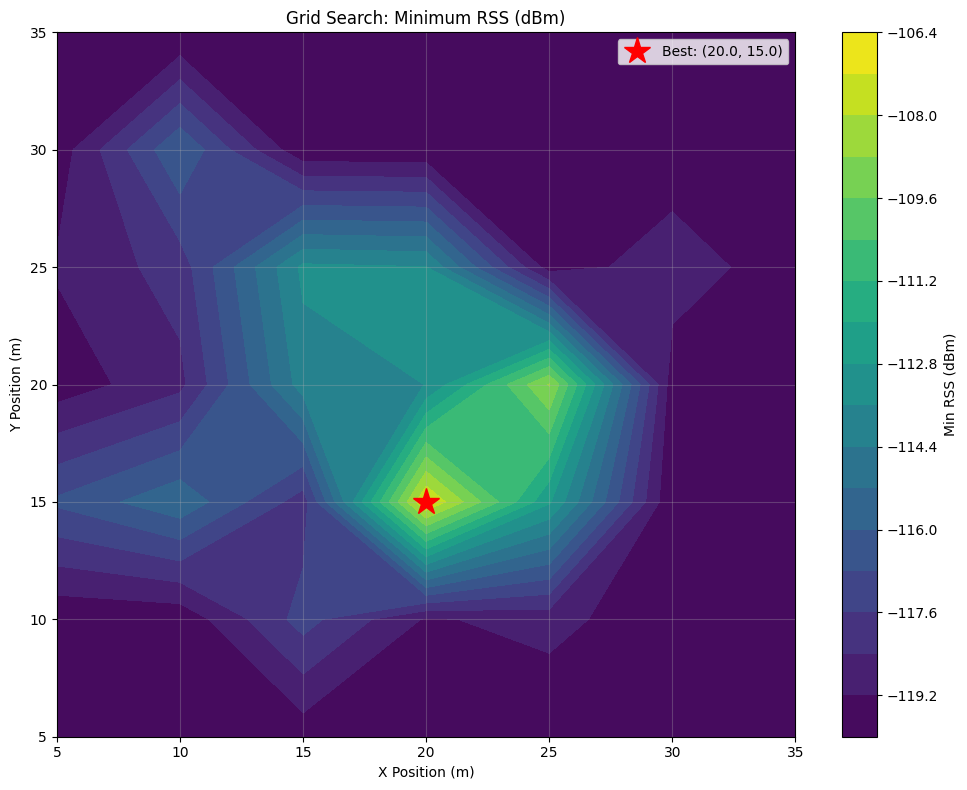

In [6]:
# EXAMPLE 1: Grid Search Optimization
# Uncomment to run

# Define search space
search_bounds = {
    'x_min': 5.0,
    'x_max': 35.0,
    'y_min': 5.0,
    'y_max': 35.0
}

# Create grid search optimizer
grid_optimizer = GridSearchAPOptimizer(
    scene=scene,
    search_bounds=search_bounds,
    grid_resolution=5.0,  # 1 meter grid spacing
    fixed_z=3.8
)

# Run optimization (this will take some time)
best_position_gs, best_rss_gs = grid_optimizer.optimize(
    samples_per_tx=500_000,
    max_depth=13,
    coverage_threshold_dbm=-100.0,
    verbose=True
)

# Plot results
grid_optimizer.plot_results(metric='min_rss_dbm')

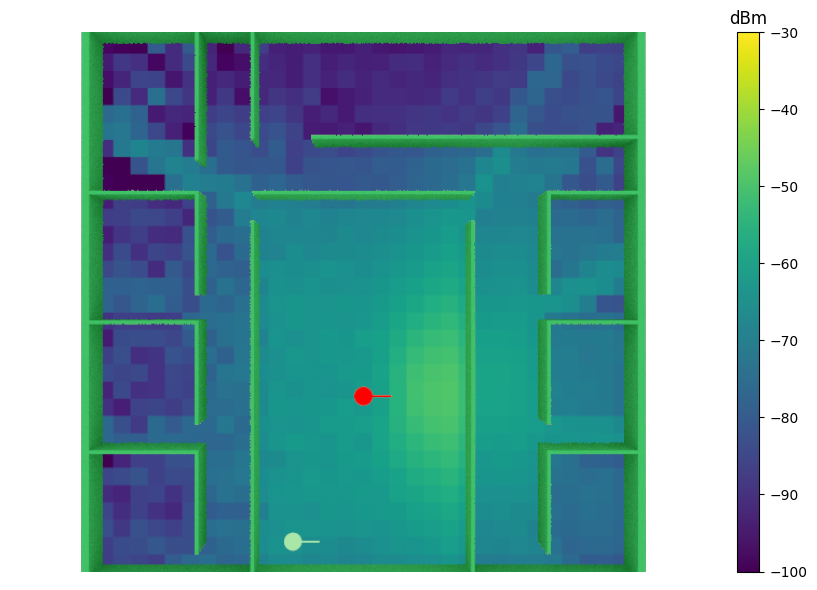

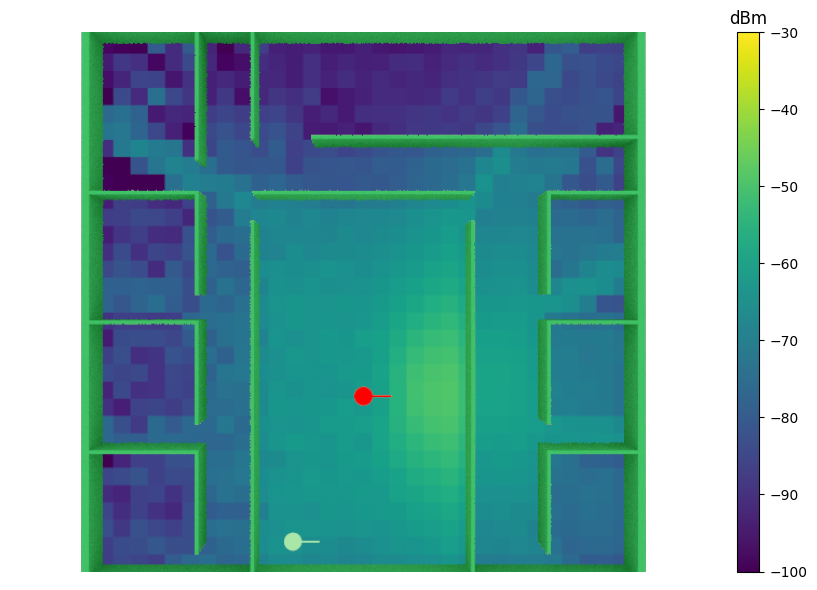

In [7]:
# rm = grid_optimizer.results['radio_maps'][np.argmax(grid_optimizer.results['min_rss_values'])]

rm = compute_radio_map_with_tx_position(scene, best_position_gs, cell_size=(1., 1.), samples_per_tx=1_000_000, max_depth=15)
cam = sionna.rt.Camera(position=[20, 20, 50],
                       look_at=[20, 20.1, 1.5])
scene.render(camera=cam,
             radio_map=rm,
             rm_metric="rss",
             rm_vmax=-30,
             rm_vmin=-100,
            #  rm_vmax=min(-30, v_max),
            #  rm_vmin=max(-100, v_min),
             rm_db_scale=True,
             rm_show_color_bar=True,
             show_orientations=True,)

In [ ]:
# EXAMPLE 2: Gradient Descent Optimization
# Uncomment to run

# Define initial position and bounds
initial_position = [20.0, 20.0]  # Starting position (x, y)
position_bounds = {
    'x_min': 5.0,
    'x_max': 35.0,
    'y_min': 5.0,
    'y_max': 35.0
}

# Create gradient descent optimizer
gd_optimizer = GradientDescentAPOptimizer(
    scene=scene,
    initial_position=initial_position,
    fixed_z=3.8,
    position_bounds=position_bounds
)

# Run optimization
final_position_gd, final_rss_gd = gd_optimizer.optimize(
    num_iterations=10,
    learning_rate=0.5,
    samples_per_tx=1_000_000,
    max_depth=15,
    use_soft_min=True,
    temperature=0.2,
    coverage_threshold_dbm=-100.0,
    verbose=True
)

# Plot optimization trajectory
gd_optimizer.plot_optimization_trajectory()

Starting Gradient Descent Optimization (PyTorch + DrJit)
  Device: cuda
  Initial position: (20.00, 20.00, 3.80)
  Learning rate: 0.5
  Iterations: 10
  Samples per iteration: 1000000
  Use soft minimum: True
  Temperature: 0.2
----------------------------------------------------------------------
log_min_rss: -105.45034790039062



Dr.Jit encountered an unrecoverable error and will now shut
down. Please re-run your program in debug mode to check for
out-of-bounds reads, writes, and other sources of undefined
behavior. You can do so by calling

   dr.set_flag(dr.JitFlag.Debug, True)

at the beginning of the program. If these additional checks
fail to pinpoint the problem, then you have likely found a
bug. We are happy to help investigate and fix the problem if
you can you create a self-contained reproducer and submit it
at https://github.com/mitsuba-renderer/drjit.

The error message of this specific failure is as follows:
>>> jit_cuda_compile(): compilation failed. Please see the PTX assembly listing and error message below:

.version 9.0
.target sm_120
.address_size 64

.entry drjit_3d7fe0e72b8951eb1d76199bfbaec453(.param .align 8 .b8 params[240]) {
    .pragma "enable_smem_spilling";

    .reg.b8  %b <184>; .reg.b16  %w<184>; .reg.b32 %r<184>;
    .reg.b64 %rd<184>; .reg.f16  %h<184>; .reg.f32 %f<184>;
    .re

In [ ]:
# EXAMPLE 3: Compare Both Methods
# Uncomment to run (requires running Examples 1 and 2 first)

# # Compare results
# comparison_results = compare_optimizers(
#     grid_optimizer.results,
#     gd_optimizer.history
# )

# # Create combined visualization
# plot_combined_comparison(grid_optimizer, gd_optimizer)

## Quick Start Example (Fast Test)

For a quick test with reduced computational requirements, use these parameters:

In [ ]:
# QUICK TEST: Fast gradient descent optimization
# This uses fewer samples and iterations for quick testing

# # Define initial position and bounds
# initial_position = [10.0, 20.0]
# position_bounds = {
#     'x_min': 8.0,
#     'x_max': 12.0,
#     'y_min': 18.0,
#     'y_max': 22.0
# }

# # Create optimizer
# quick_optimizer = GradientDescentAPOptimizer(
#     scene=scene,
#     initial_position=initial_position,
#     fixed_z=3.8,
#     position_bounds=position_bounds
# )

# # Run with reduced parameters for quick test
# final_pos, final_rss = quick_optimizer.optimize(
#     num_iterations=20,           # Fewer iterations
#     learning_rate=0.3,
#     samples_per_tx=50_000,       # Fewer samples (faster but less accurate)
#     max_depth=8,                 # Lower depth
#     use_soft_min=True,
#     temperature=0.1,
#     verbose=True
# )

# # Plot results
# quick_optimizer.plot_optimization_trajectory()

## Gradient Flow Test: Transmitter Position with PathSolver

Testing if gradients can flow through transmitter position using PathSolver with @dr.wrap decorator (following Sionna API example).

In [4]:
import torch
import drjit as dr
from sionna.rt import PathSolver

# Create PathSolver
p_solver = PathSolver()
p_solver.loop_mode = "evaluated"  # Needed for gradient computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get initial transmitter position
tx = scene.transmitters["Tx00"]
print(tx.position[0][0])
initial_x = float(tx.position[0][0])
initial_y = float(tx.position[1][0])
fixed_z = float(tx.position[2][0])

print(f"Initial transmitter position: ({initial_x:.2f}, {initial_y:.2f}, {fixed_z:.2f})")

# Wrap path computation function within a PyTorch context
@dr.wrap(source="torch", target="drjit")
def compute_paths(tx_x, tx_y):
    # Update transmitter position
    # Try to set position using DrJit arrays
    for tx in scene.transmitters.values():
        tx.position = [tx_x.array, tx_y.array, fixed_z]
    
    # Compute paths
    paths = p_solver(scene)

    
    # Compute path gain (sum of squared path coefficients)
    gain = dr.sum(dr.sum(cpx_abs_square(paths.a)))
    
    return gain

# PyTorch trainable parameters for transmitter position
tx_x = torch.tensor(initial_x, requires_grad=True, device=device)
tx_y = torch.tensor(initial_y, requires_grad=True, device=device)

optimizer = torch.optim.Adam([tx_x, tx_y], lr=0.1)

print("\n" + "="*60)
print("Testing gradient flow through transmitter position...")
print("="*60)

# Single optimization step to test gradient flow
# try:
loss = -compute_paths(tx_x, tx_y)

print(f"\nBefore backward pass:")
print(f"  Loss: {loss.item():.6e}")
print(f"  tx_x.grad: {tx_x.grad}")
print(f"  tx_y.grad: {tx_y.grad}")

optimizer.zero_grad()
loss.backward()

print(f"\nAfter backward pass:")
print(f"  tx_x.grad: {tx_x.grad}")
print(f"  tx_y.grad: {tx_y.grad}")

if tx_x.grad is not None and tx_y.grad is not None:
    print(f"\n✅ SUCCESS: Gradients flow through transmitter position!")
    print(f"  Gradient magnitudes: ||grad_x|| = {abs(tx_x.grad.item()):.6e}, ||grad_y|| = {abs(tx_y.grad.item()):.6e}")
    
    # Take one optimization step
    optimizer.step()
    print(f"\nAfter optimizer step:")
    print(f"  New position: ({tx_x.item():.2f}, {tx_y.item():.2f})")
    print(f"  Position change: Δx = {tx_x.item() - initial_x:.4f}, Δy = {tx_y.item() - initial_y:.4f}")
else:
    print(f"\n❌ FAILED: Gradients are None - cannot optimize transmitter position")
        
# except Exception as e:
#     print(f"\n❌ ERROR: {type(e).__name__}: {e}")
#     print(f"\nThis confirms that transmitter position cannot be optimized using @dr.wrap")
#     print("Reason: mi.Point3f cannot accept DrJit Float arrays")

10.0
Initial transmitter position: (10.00, 20.00, 3.80)

Testing gradient flow through transmitter position...

Before backward pass:
  Loss: -1.757144e-08
  tx_x.grad: None
  tx_y.grad: None

After backward pass:
  tx_x.grad: -2.1635915281592588e-10
  tx_y.grad: 2.128389908762074e-09

✅ SUCCESS: Gradients flow through transmitter position!
  Gradient magnitudes: ||grad_x|| = 2.163592e-10, ||grad_y|| = 2.128390e-09

After optimizer step:
  New position: (10.00, 19.98)
  Position change: Δx = 0.0021, Δy = -0.0175


## Implementation Notes and Best Practices

### Key Concepts

#### 1. **Objective Function: Minimum RSS**
- We optimize the **minimum RSS** value across the radio map
- This improves worst-case coverage (raises the floor)
- Alternative: Could optimize average RSS, coverage area, or custom metrics

#### 2. **Soft Minimum vs. Hard Minimum**
- **Hard minimum**: `tf.reduce_min()` - exact but poor gradients (sparse)
- **Soft minimum**: LogSumExp-based - smooth gradients, better for optimization
- Temperature parameter controls smoothness (lower = closer to hard min)

#### 3. **Differentiable Ray Tracing**
- Sionna's RadioMapSolver is fully differentiable
- Gradients flow through:
  - Ray path geometry
  - Material interactions
  - Antenna patterns
  - Position changes
- Enables gradient-based optimization of scene parameters

#### 4. **Position Constraints**
- Bounds are enforced via `tf.clip_by_value()` after each gradient step
- Alternative: Could use projected gradient descent or Lagrangian methods
- For wall-mounting: Use manifold constraints (see reflector positioning code)

---

### Hyperparameter Guidelines

#### Grid Search
| Parameter | Typical Value | Notes |
|-----------|--------------|-------|
| `grid_resolution` | 0.5 - 2.0 m | Finer grid = more accurate but slower |
| `samples_per_tx` | 100k - 1M | Higher = more accurate RSS, longer compute |
| `max_depth` | 5 - 15 | More reflections = more realistic but slower |

#### Gradient Descent
| Parameter | Typical Value | Notes |
|-----------|--------------|-------|
| `learning_rate` | 0.1 - 1.0 | Start high, reduce if diverging |
| `num_iterations` | 20 - 100 | Monitor convergence, stop early if converged |
| `samples_per_tx` | 50k - 500k | Trade-off: accuracy vs. speed |
| `temperature` | 0.05 - 0.2 | Lower = closer to hard min, less smooth |
| `use_soft_min` | True | Recommended for better gradients |

---

### Expected Performance

Based on the roadmap (Phase 1 targets):

✅ **Speed**: Gradient descent should be **50-100× faster** than grid search  
✅ **Convergence**: Should reach near-optimal solution in **<100 iterations**  
✅ **Quality**: Should achieve **within 1-2 dB** of global optimum  

---

### Troubleshooting

**Problem**: Gradient descent doesn't improve
- ✓ Check learning rate (try reducing by 10×)
- ✓ Increase `samples_per_tx` for more stable gradients
- ✓ Try different initial positions
- ✓ Use soft minimum (`use_soft_min=True`)

**Problem**: Optimization is very slow
- ✓ Reduce `samples_per_tx` (start with 50k)
- ✓ Reduce `max_depth` (try 8-10)
- ✓ Use smaller grid for grid search

**Problem**: Position goes out of bounds
- ✓ Check `position_bounds` are set correctly
- ✓ Reduce learning rate
- ✓ The optimizer automatically clips, but large LR can cause oscillation

---

### Next Steps (Phase 2+)

After validating Phase 1, the roadmap suggests:

1. **Phase 2**: Joint AP + single RIS optimization
   - Hierarchical optimization (different learning rates)
   - Manifold constraints for wall-mounted RIS
   
2. **Phase 3**: Multi-AP, multi-RIS joint optimization
   - Tri-level hierarchical optimizer
   - Annealing schedules
   - Different environments (office, warehouse, corridor)

3. **Advanced Features**:
   - Discontinuity smoothing (sigmoid-based, see Eertmans et al.)
   - Learned annealing schedules
   - Multi-objective optimization (coverage + capacity + cost)